

# Visualizing epoched data

This tutorial shows how to plot epoched data as time series, how to plot the
spectral density of epoched data, how to plot epochs as an imagemap, and how to
plot the sensor locations and projectors stored in `~mne.Epochs` objects.

We'll start by importing the modules we need, loading the continuous (raw)
sample data, and cropping it to save memory:


In [1]:
import os
import mne
%matplotlib inline

In [2]:
SAMPLE_DATA_DIR = os.path.join(os.environ["HOME"],
                           "mne_data",
                           "MNE-sample-data")

sample_data_raw_file = (os.path.join(SAMPLE_DATA_DIR, 'MEG',
                                     'sample','sample_audvis_raw.fif'))
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False).crop(tmax=120)

To create the `~mne.Epochs` data structure, we'll extract the event
IDs stored in the :term:`stim channel`, map those integer event IDs to more
descriptive condition labels using an event dictionary, and pass those to the
`~mne.Epochs` constructor, along with the `~mne.io.Raw` data and the
desired temporal limits of our epochs, ``tmin`` and ``tmax`` (for a
detailed explanation of these steps, see `tut-epochs-class`).



In [3]:
events = mne.find_events(raw, stim_channel='STI 014')
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'face': 5, 'button': 32}
epochs = mne.Epochs(raw, events, tmin=-0.2, tmax=0.5, event_id=event_dict,
                    preload=True)
del raw

176 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
176 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 176 events and 421 original time points ...
1 bad epochs dropped


## Plotting ``Epochs`` as time series

.. admonition:: Interactivity in pipelines and scripts
    :class: sidebar hint

    To use the interactive features of the `~mne.Epochs.plot` method
    when running your code non-interactively, pass the ``block=True``
    parameter, which halts the Python interpreter until the figure window is
    closed. That way, any channels or epochs that you mark as "bad" will be
    taken into account in subsequent processing steps.

To visualize epoched data as time series (one time series per channel), the
`mne.Epochs.plot` method is available. It creates an interactive window
where you can scroll through epochs and channels, enable/disable any
unapplied :term:`SSP projectors <projector>` to see how they affect the
signal, and even manually mark bad channels (by clicking the channel name) or
bad epochs (by clicking the data) for later dropping. Channels marked "bad"
will be shown in light grey color and will be added to
``epochs.info['bads']``; epochs marked as bad will be indicated as ``'USER'``
in ``epochs.drop_log``.

Here we'll plot only the "catch" trials from the `sample dataset
<sample-dataset>`, and pass in our events array so that the button press
responses also get marked (we'll plot them in red, and plot the "face" events
defining time zero for each epoch in blue). We also need to pass in
our ``event_dict`` so that the `~mne.Epochs.plot` method will know what
we mean by "button" — this is because subsetting the conditions by
calling ``epochs['face']`` automatically purges the dropped entries from
``epochs.event_id``:



Using matplotlib as 2D backend.


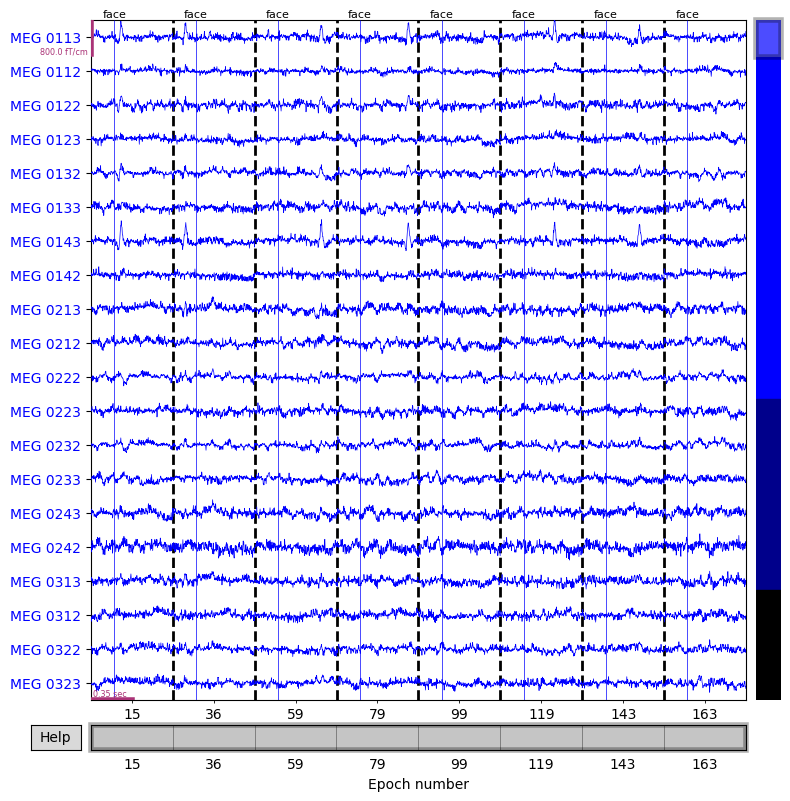

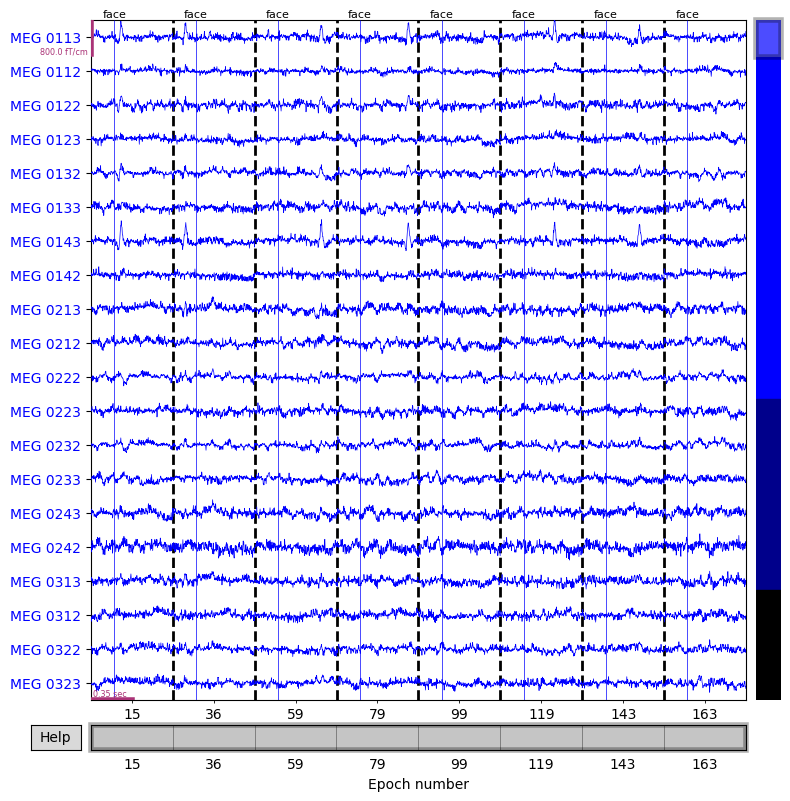

In [4]:
catch_trials_and_buttonpresses = mne.pick_events(events, include=[5, 32])
epochs['face'].plot(events=catch_trials_and_buttonpresses, event_id=event_dict,
                    event_color=dict(button='red', face='blue'))

To see all sensors at once, we can use butterfly mode and group by selection:



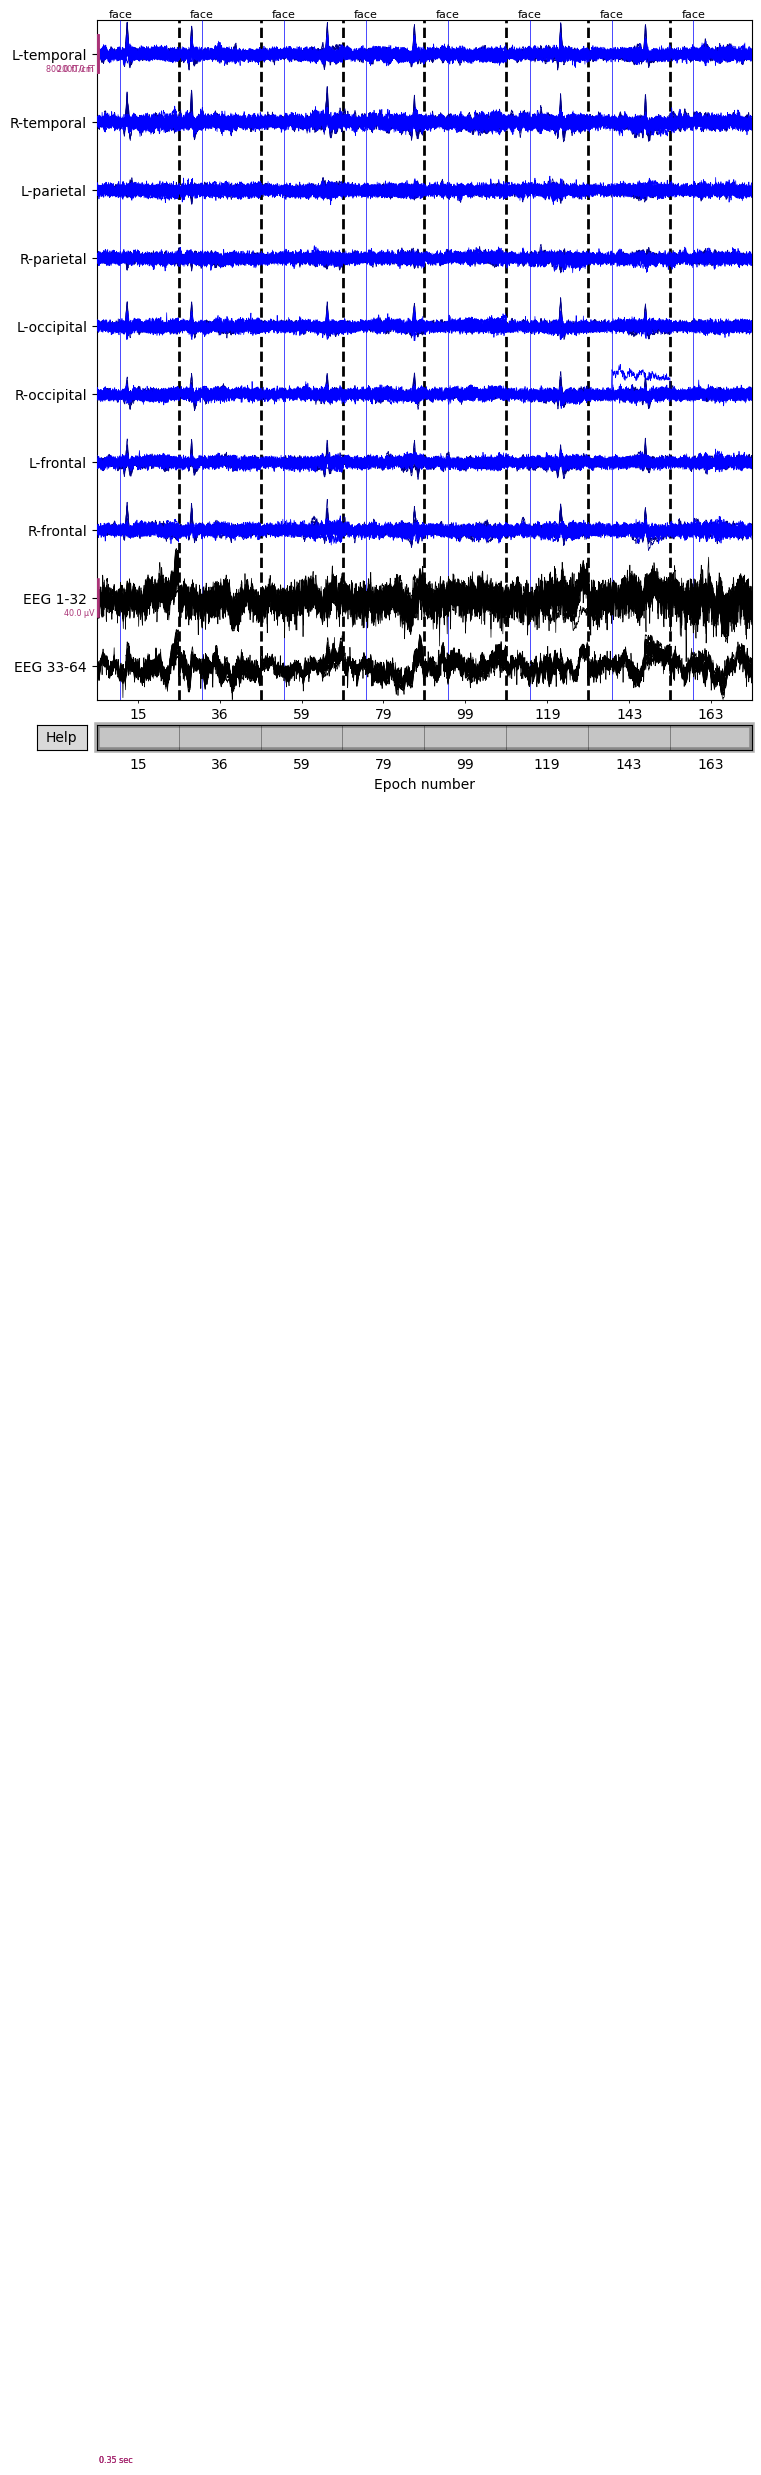

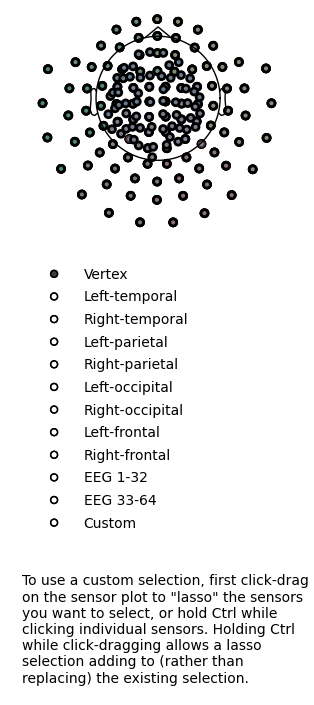

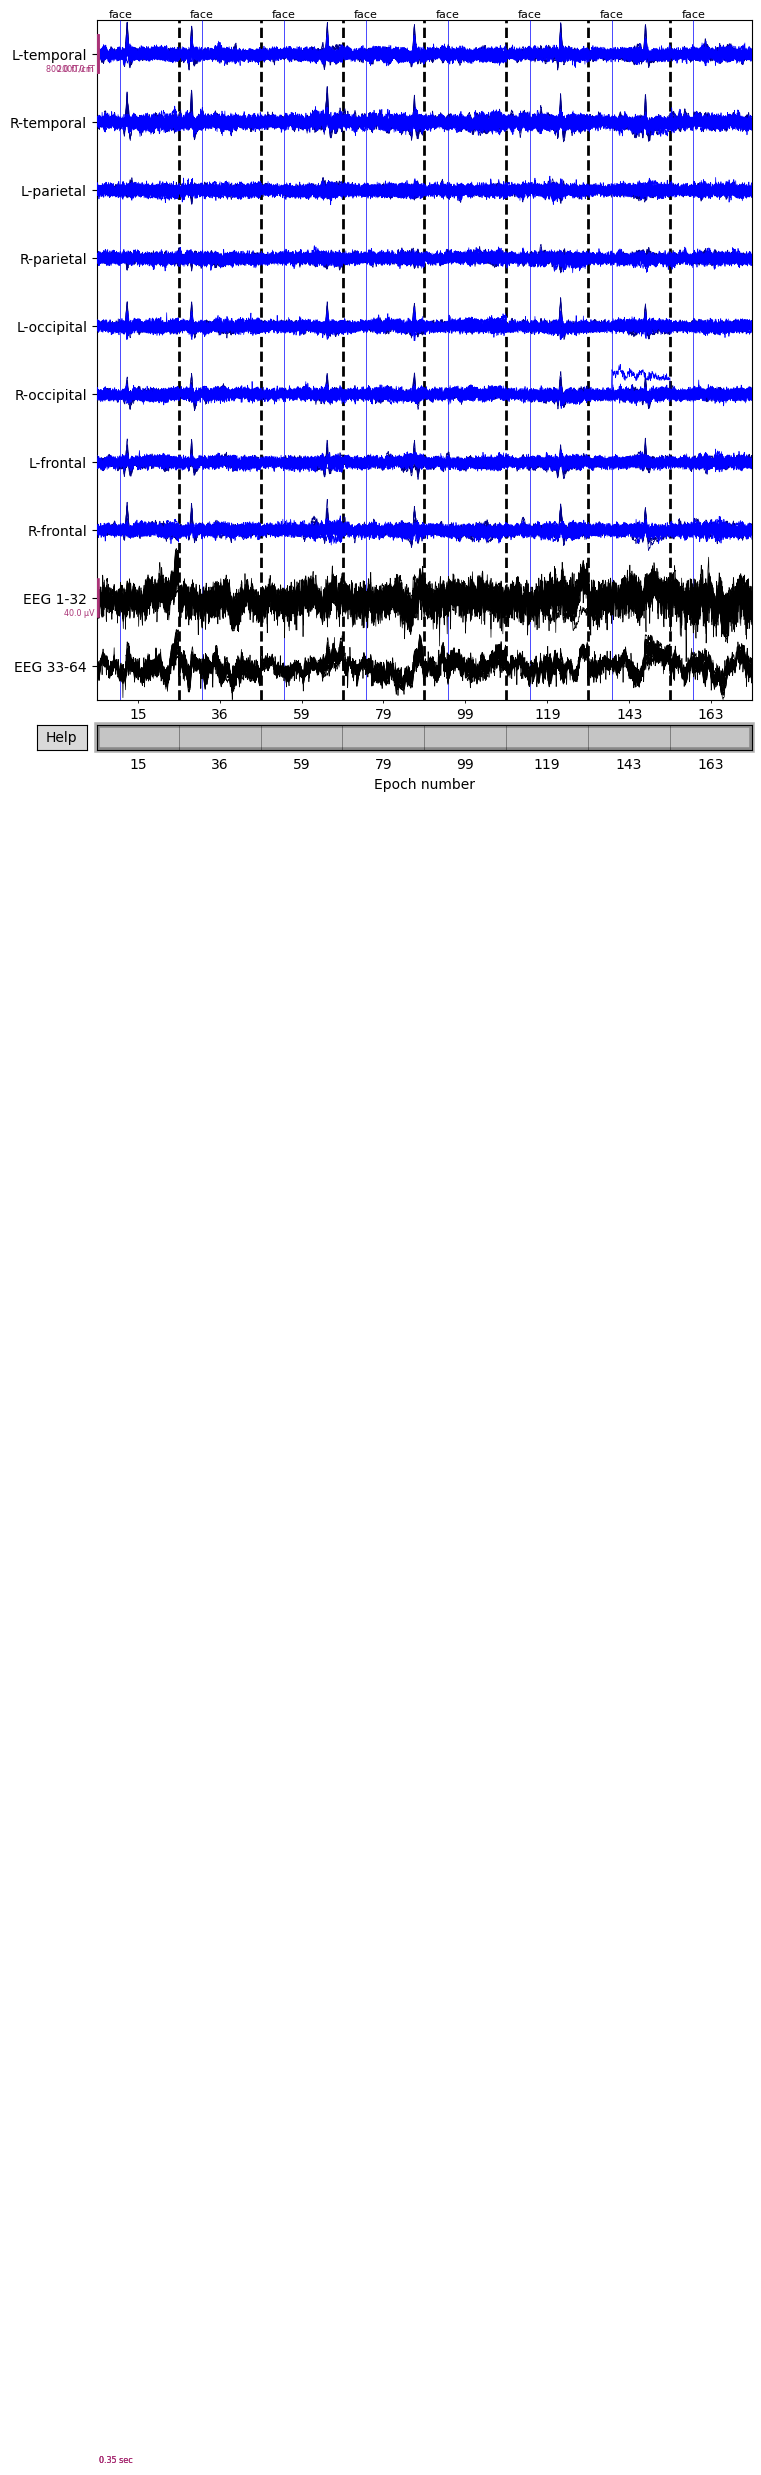

In [5]:
epochs['face'].plot(events=catch_trials_and_buttonpresses, event_id=event_dict,
                    event_color=dict(button='red', face='blue'),
                    group_by='selection', butterfly=True)

## Plotting projectors from an ``Epochs`` object

In the plot above we can see heartbeat artifacts in the magnetometer
channels, so before we continue let's load ECG projectors from disk and apply
them to the data:



In [6]:
ecg_proj_file = os.path.join(SAMPLE_DATA_DIR, 'MEG',
                             'sample','sample_audvis_ecg-proj.fif')

ecg_projs = mne.read_proj(ecg_proj_file)
epochs.add_proj(ecg_projs)
epochs.apply_proj()

    Read a total of 6 projection items:
        ECG-planar-999--0.200-0.400-PCA-01 (1 x 203)  idle
        ECG-planar-999--0.200-0.400-PCA-02 (1 x 203)  idle
        ECG-axial-999--0.200-0.400-PCA-01 (1 x 102)  idle
        ECG-axial-999--0.200-0.400-PCA-02 (1 x 102)  idle
        ECG-eeg-999--0.200-0.400-PCA-01 (1 x 59)  idle
        ECG-eeg-999--0.200-0.400-PCA-02 (1 x 59)  idle
6 projection items deactivated
Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...


Number of events,175
Events,auditory/left: 41auditory/right: 40button: 8face: 8visual/left: 40visual/right: 38
Time range,-0.200 – 0.499 sec
Baseline,-0.200 – 0.000 sec


Just as we saw in the `tut-section-raw-plot-proj` section, we can plot
the projectors present in an `~mne.Epochs` object using the same
`~mne.Epochs.plot_projs_topomap` method. Since the original three
empty-room magnetometer projectors were inherited from the
`~mne.io.Raw` file, and we added two ECG projectors for each sensor
type, we should see nine projector topomaps:



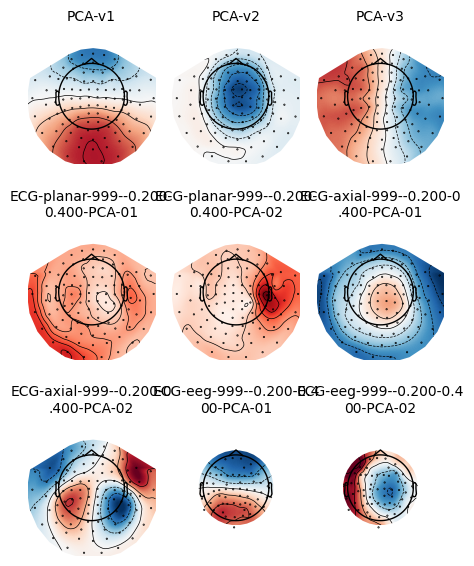

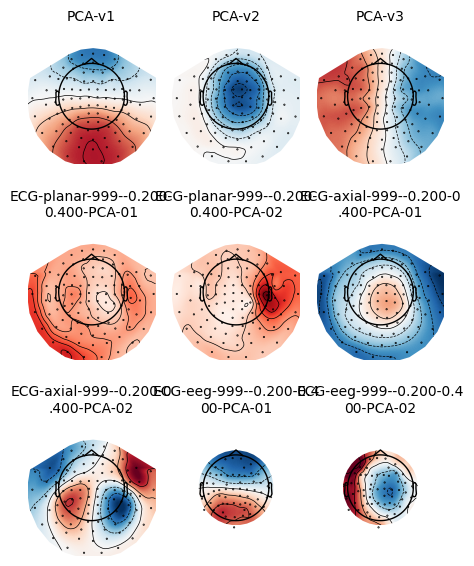

In [7]:
epochs.plot_projs_topomap(vlim='joint')

Note that these field maps illustrate aspects of the signal that *have
already been removed* (because projectors in `~mne.io.Raw` data are
applied by default when epoching, and because we called
`~mne.Epochs.apply_proj` after adding additional ECG projectors from
file). You can check this by examining the ``'active'`` field of the
projectors:



In [8]:
print(all(proj['active'] for proj in epochs.info['projs']))

True


## Plotting sensor locations

Just like `~mne.io.Raw` objects, `~mne.Epochs` objects
keep track of sensor locations, which can be visualized with the
`~mne.Epochs.plot_sensors` method:



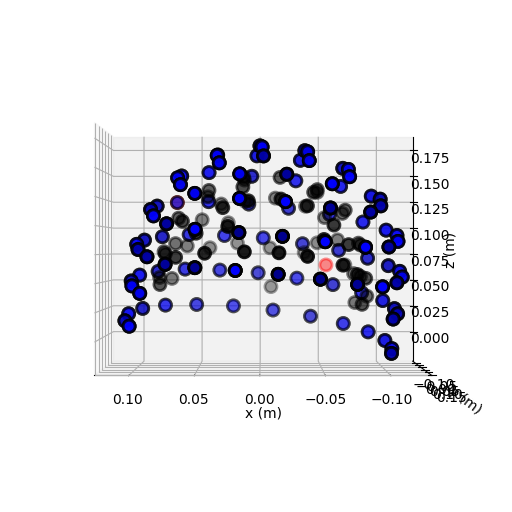

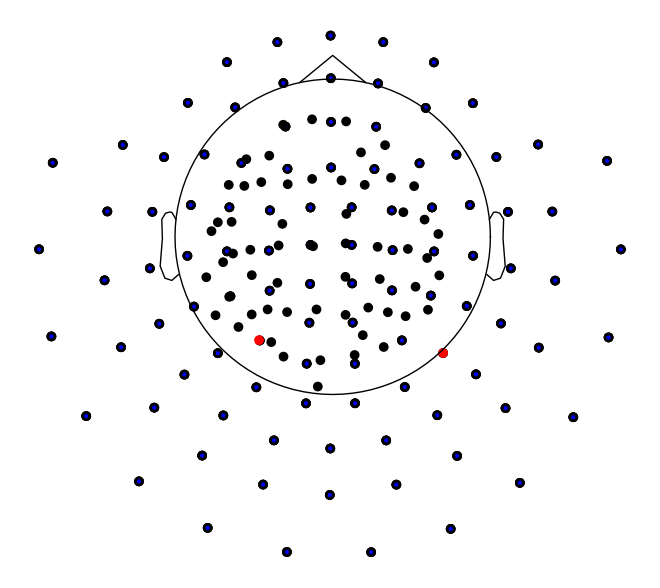

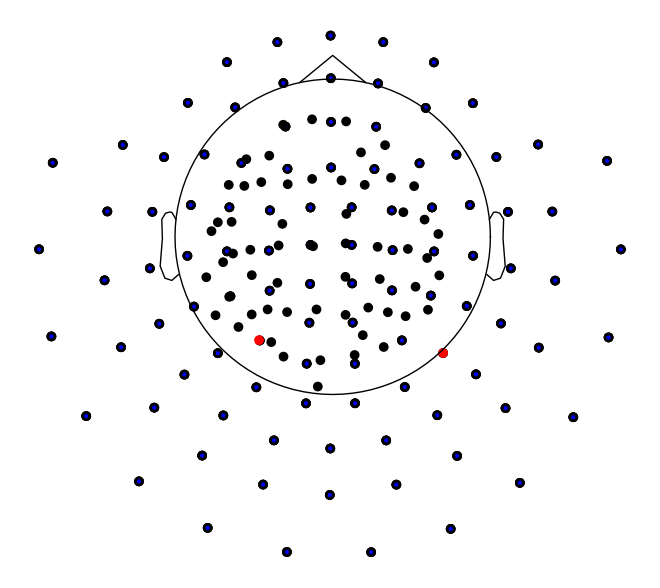

In [9]:
epochs.plot_sensors(kind='3d', ch_type='all')
epochs.plot_sensors(kind='topomap', ch_type='all')

## Plotting the power spectrum of ``Epochs``

Again, just like `~mne.io.Raw` objects, :class:`~mne.Epochs` objects
can be converted to `spectral density`_ via
:meth:`~mne.Epochs.compute_psd`, which can then be plotted using the
:class:`~mne.time_frequency.EpochsSpectrum`'s
:meth:`~mne.time_frequency.EpochsSpectrum.plot` method.



    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/Users/jonghang/opt/anaconda3/envs/torch311/lib/python3.11/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


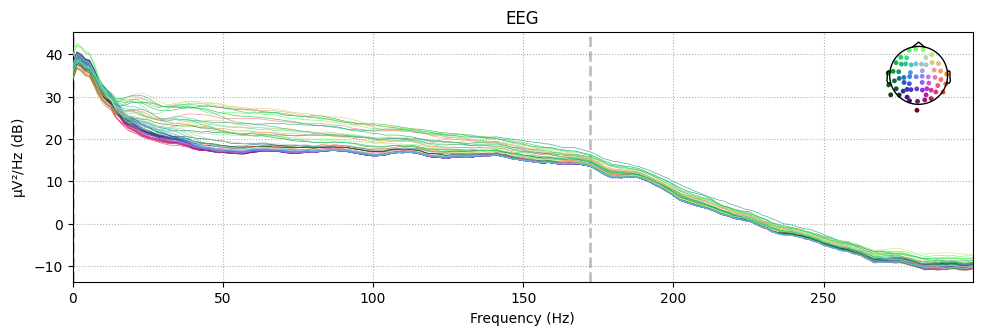

In [10]:
epochs['auditory'].compute_psd().plot(picks='eeg')

It is also possible to plot spectral power estimates across sensors as a
scalp topography, using the :class:`~mne.time_frequency.EpochsSpectrum`'s
:meth:`~mne.time_frequency.EpochsSpectrum.plot_topomap` method. The default
parameters will plot five frequency bands (δ, θ, α, β, γ), will compute power
based on magnetometer channels (if present), and will plot the power
estimates on a dB-like log-scale:



    Using multitaper spectrum estimation with 7 DPSS windows


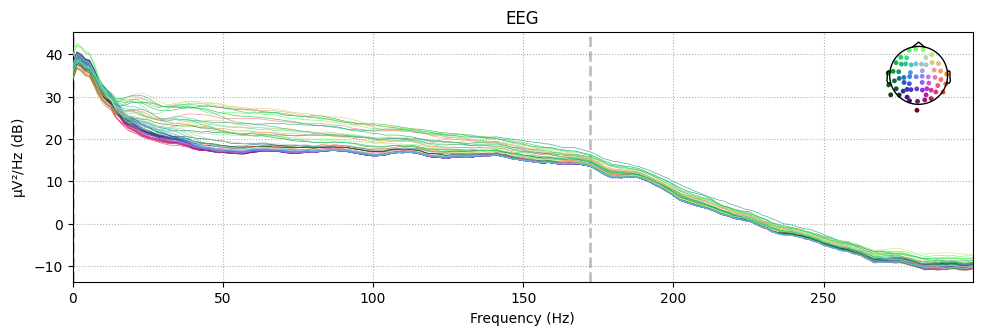

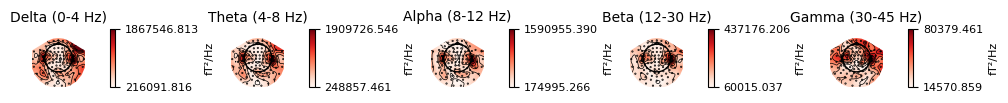

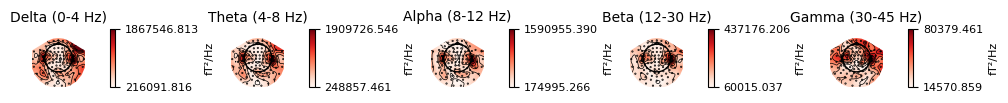

In [11]:
spectrum = epochs['visual/right'].compute_psd()
spectrum.plot_topomap()

<div class="alert alert-info"><h4>Note</h4><p>Prior to the addition of the :class:`~mne.time_frequency.EpochsSpectrum`
   class, the above plots were possible via::

       epochs['auditory'].plot_psd(picks='eeg')
       epochs['visual/right'].plot_psd_topomap()

   The :meth:`~mne.Epochs.plot_psd` and `~mne.Epochs.plot_psd_topomap`
   methods of :class:`~mne.Epochs` objects are still provided to support
   legacy analysis scripts, but new code should instead use the
   :class:`~mne.time_frequency.EpochsSpectrum` object API.</p></div>

Just like `~mne.Epochs.plot_projs_topomap`,
`EpochsSpectrum.plot_topomap()<mne.time_frequency.EpochsSpectrum.plot_topomap>`
has a ``vlim='joint'`` option for fixing the colorbar limits jointly across
all subplots, to give a better sense of the relative magnitude in each
frequency band. You can change which channel type is used via the
``ch_type`` parameter, and if you want to view different frequency bands than
the defaults, the ``bands`` parameter takes a :class:`dict`, with keys
providing a subplot title and values providing either single frequency bins
to plot, or lower/upper frequency band edges:



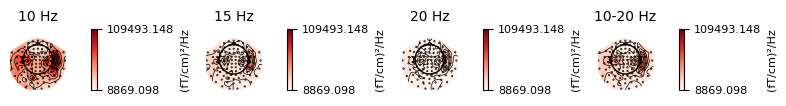

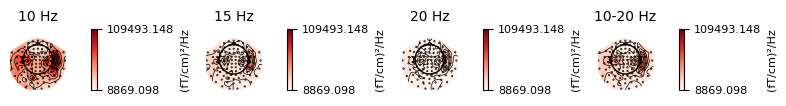

In [12]:
bands = {'10 Hz': 10, '15 Hz': 15, '20 Hz': 20, '10-20 Hz': (10, 20)}
spectrum.plot_topomap(bands=bands, vlim='joint', ch_type='grad')

If you prefer untransformed power estimates, you can pass ``dB=False``. It is
also possible to normalize the power estimates by dividing by the total power
across all frequencies, by passing ``normalize=True``. See the docstring of
`~mne.time_frequency.EpochsSpectrum.plot_topomap` for details.


## Plotting ``Epochs`` as an image map

A convenient way to visualize many epochs simultaneously is to plot them as
an image map, with each row of pixels in the image representing a single
epoch, the horizontal axis representing time, and each pixel's color
representing the signal value at that time sample for that epoch. Of course,
this requires either a separate image map for each channel, or some way of
combining information across channels. The latter is possible using the
`~mne.Epochs.plot_image` method; the former can be achieved with the
`~mne.Epochs.plot_image` method (one channel at a time) or with the
`~mne.Epochs.plot_topo_image` method (all sensors at once).

By default, the image map generated by `~mne.Epochs.plot_image` will be
accompanied by a scalebar indicating the range of the colormap, and a time
series showing the average signal across epochs and a bootstrapped 95%
confidence band around the mean. `~mne.Epochs.plot_image` is a highly
customizable method with many parameters, including customization of the
auxiliary colorbar and averaged time series subplots. See the docstrings of
`~mne.Epochs.plot_image` and `mne.viz.plot_compare_evokeds` (which is
used to plot the average time series) for full details. Here we'll show the
mean across magnetometers for all epochs with an auditory stimulus:



Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


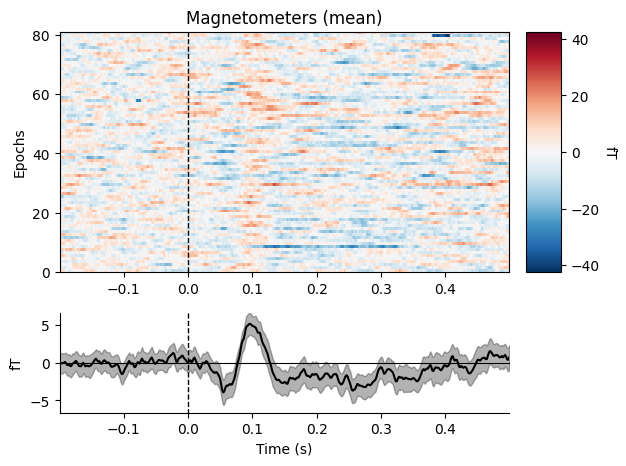

[<Figure size 640x480 with 3 Axes>]

In [13]:
epochs['auditory'].plot_image(picks='mag', combine='mean')

To plot image maps for individual sensors or a small group of sensors, use
the ``picks`` parameter. Passing ``combine=None`` (the default) will yield
separate plots for each sensor in ``picks``; passing ``combine='gfp'`` will
plot the global field power (useful for combining sensors that respond with
opposite polarity).



Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated


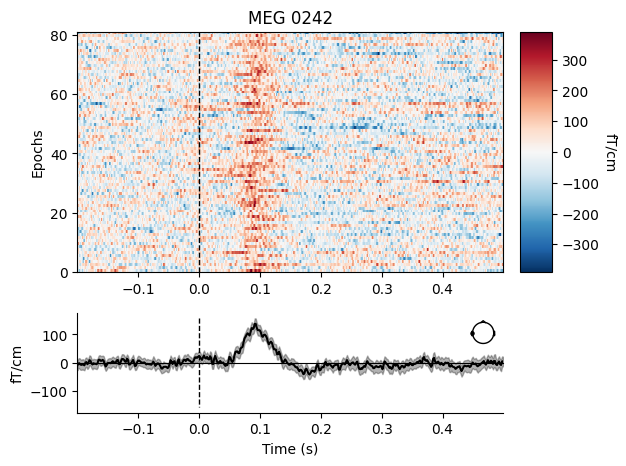

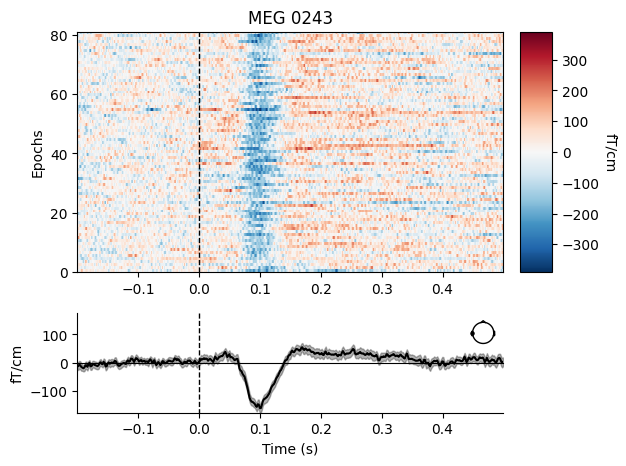

Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


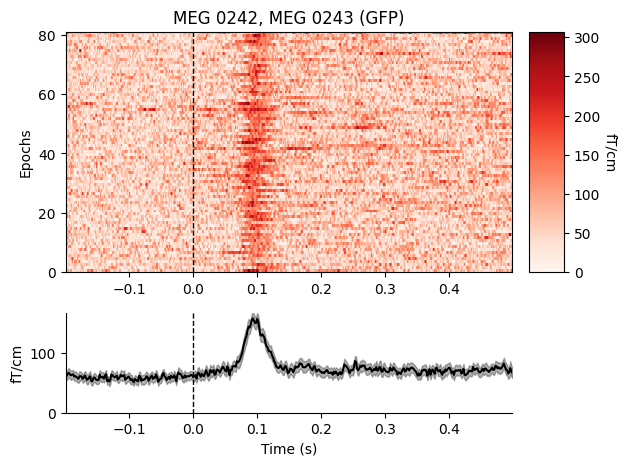

[<Figure size 640x480 with 3 Axes>]

In [14]:
epochs['auditory'].plot_image(picks=['MEG 0242', 'MEG 0243'])
epochs['auditory'].plot_image(picks=['MEG 0242', 'MEG 0243'], combine='gfp')

To plot an image map for *all* sensors, use
`~mne.Epochs.plot_topo_image`, which is optimized for plotting a large
number of image maps simultaneously, and (in interactive sessions) allows you
to click on each small image map to pop open a separate figure with the
full-sized image plot (as if you had called `~mne.Epochs.plot_image` on
just that sensor). At the small scale shown in this tutorial it's hard to see
much useful detail in these plots; it's often best when plotting
interactively to maximize the topo image plots to fullscreen. The default is
a figure with black background, so here we specify a white background and
black foreground text. By default `~mne.Epochs.plot_topo_image` will
show magnetometers and gradiometers on the same plot (and hence not show a
colorbar, since the sensors are on different scales) so we'll also pass a
`~mne.channels.Layout` restricting each plot to one channel type.
First, however, we'll also drop any epochs that have unusually high signal
levels, because they can cause the colormap limits to be too extreme and
therefore mask smaller signal fluctuations of interest.



    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 015', 'EEG 016', 'EEG 023', 'EEG 039', 'EEG 041', 'EEG 044', 'EEG 045', 'EEG 046', 'EEG 047', 'EEG 048', 'EEG 049', 'EEG 050', 'EEG 051', 'EEG 052', 'EEG 054', 'EEG 055', 'EEG 056', 'EEG 057', 'EEG 058', 'EEG 059']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007', 'EEG 048', 'EEG 055']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 007']
    Rejecting  epoch based on MAG : ['MEG 1711']
8 bad epochs dropped
Removing projector <Projection | ECG-planar-999--0.200-0.400-PCA-01, active : True, n_channels : 203>
Removing projector <Projection | ECG-planar-999--0.200-0.400-PCA-02, active : True, 

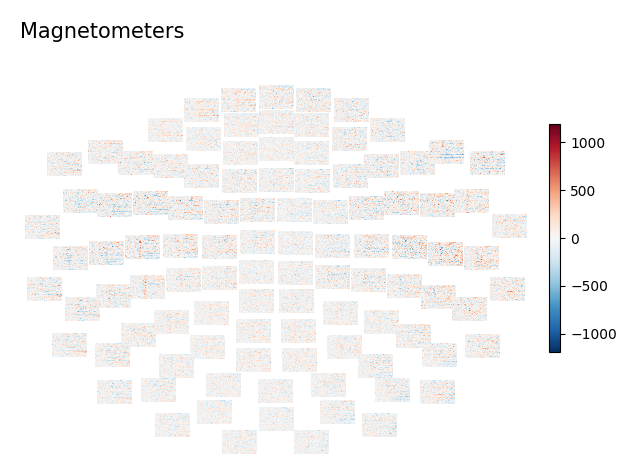

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | ECG-axial-999--0.200-0.400-PCA-01, active : True, n_channels : 102>
Removing projector <Projection | ECG-axial-999--0.200-0.400-PCA-02, active : True, n_channels : 102>
Removing projector <Projection | ECG-eeg-999--0.200-0.400-PCA-01, active : True, n_channels : 59>
Removing projector <Projection | ECG-eeg-999--0.200-0.400-PCA-02, active : True, n_channels : 59>


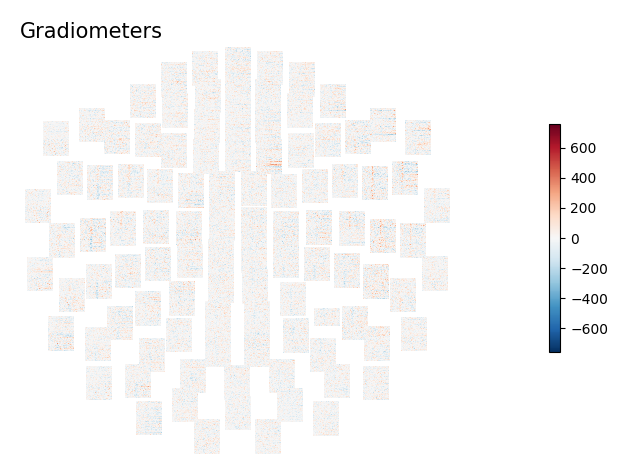

In [15]:
reject_criteria = dict(mag=3000e-15,     # 3000 fT
                       grad=3000e-13,    # 3000 fT/cm
                       eeg=150e-6)       # 150 µV
epochs.drop_bad(reject=reject_criteria)

for ch_type, title in dict(mag='Magnetometers', grad='Gradiometers').items():
    layout = mne.channels.find_layout(epochs.info, ch_type=ch_type)
    epochs['auditory/left'].plot_topo_image(layout=layout, fig_facecolor='w',
                                            font_color='k', title=title)

To plot image maps for all EEG sensors, pass an EEG layout as the ``layout``
parameter of `~mne.Epochs.plot_topo_image`. Note also here the use of
the ``sigma`` parameter, which smooths each image map along the vertical
dimension (across epochs) which can make it easier to see patterns across the
small image maps (by smearing noisy epochs onto their neighbors, while
reinforcing parts of the image where adjacent epochs are similar). However,
``sigma`` can also disguise epochs that have persistent extreme values and
maybe should have been excluded, so it should be used with caution.



Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | ECG-planar-999--0.200-0.400-PCA-01, active : True, n_channels : 203>
Removing projector <Projection | ECG-planar-999--0.200-0.400-PCA-02, active : True, n_channels : 203>
Removing projector <Projection | ECG-axial-999--0.200-0.400-PCA-01, active : True, n_channels : 102>
Removing projector <Projection | ECG-axial-999--0.200-0.400-PCA-02, active : True, n_channels : 102>


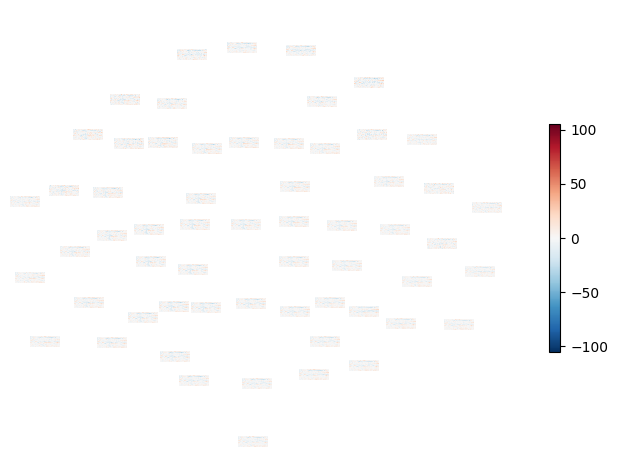

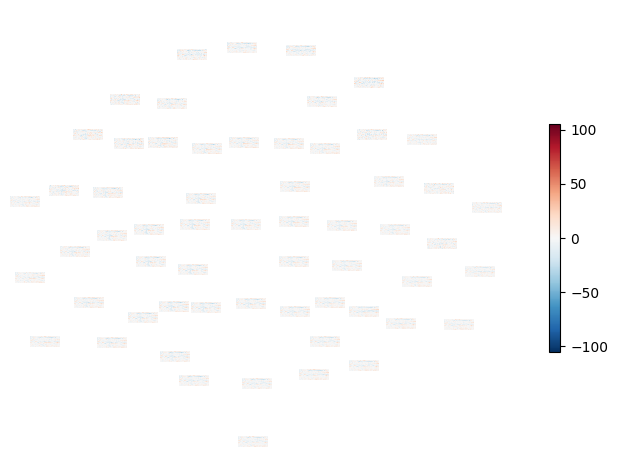

In [16]:
layout = mne.channels.find_layout(epochs.info, ch_type='eeg')
epochs['auditory/left'].plot_topo_image(layout=layout, fig_facecolor='w',
                                        font_color='k', sigma=1)